# The University of Hong Kong
## DASC7600 Data Science Project 2024
## Curves Similarity Analysis - Hong Kong

In [1]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from typing import List

import covid_module

# Settings
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

%matplotlib inline

# Functions

In [2]:
def plot_case_count_line_chart(count_df: pd.DataFrame,
                               cntry_cd: str,
                               norm_ind: bool=True) -> None:
    count_temp = count_df.copy()
    date_list = count_temp.index
    
    cntry_cnt_list = count_temp['HK']
    if norm_ind == True:
        cntry_cnt_list /= sum(cntry_cnt_list)
    
    # Figure and axis
    fig, ax = plt.subplots(figsize=(8, 3))
    title_str = 'Number of New Covid-19 Cases'
    x_label_str = 'Date'
    y_label_str = 'New Case Counts'
    
    # Plot line chart
    simlr_cntry_cnt_list = count_temp[cntry_cd]
    if norm_ind == True:
        title_str = 'New Covid-19 Curves (Normalized)'
        simlr_cntry_cnt_list /= sum(simlr_cntry_cnt_list)
        y_label_str = 'New Case Counts (Normalized)'
    
    ax.plot_date(date_list, cntry_cnt_list,
                 marker='', linestyle='-', label='HK')
    
    ax.plot_date(date_list, simlr_cntry_cnt_list,
                 marker='', linestyle='-', label=cntry_cd)
    
    # Title, x-axis label and y-axis label
    plt.title(title_str) 
    plt.xlabel(x_label_str)
    plt.ylabel(y_label_str)
    
    # Legend
    plt.legend(loc="upper right")
    
    plt.show()

# Load Data

In [3]:
# Read csv files
covid_global_new_case_cnt_std = pd.read_csv('./data/std_data/global/covid_global_new_case_count_std.csv')
covid_hk_case_cnt_std = pd.read_csv('./data/std_data/hk/covid_hk_case_count_std.csv')
global_lat_long_std = pd.read_csv('./data/std_data/global/global_lat_long_std.csv')

In [4]:
for df in [covid_hk_case_cnt_std,
           covid_global_new_case_cnt_std]:
    df \
        .drop(['report_year', 'report_month', 'report_year_month', 'report_day'],
              axis=1,
              inplace=True,
              errors='ignore')
    
    df['report_date'] = pd.to_datetime(df['report_date'], format='%Y%m%d')

In [5]:
# Rename columns
covid_hk_case_cnt_std.rename(columns={'new_case_cnt': 'HK'}, inplace=True)

# Weekly new case count
# Transform the report date to next Sunday 
covid_hk_case_cnt_std['report_weekday'] = covid_hk_case_cnt_std["report_date"].dt.dayofweek

covid_hk_case_cnt_std['report_date'] = covid_hk_case_cnt_std["report_date"] \
    - pd.to_timedelta(covid_hk_case_cnt_std['report_weekday'], 'd') \
    + pd.Timedelta(6, 'd')

# Obtain the weekly counts via GroupBy
covid_hk_case_cnt_std = covid_hk_case_cnt_std \
    .groupby('report_date') \
    ['HK'] \
    .sum() \
    .reset_index()

In [6]:
# covid_hk_case_cnt_std: from 2020-01-12 to 2023-01-29
# covid_global_new_case_count_std: from 2020-01-05 to 2024-08-11
covid_hk_global_new_case_cnt = covid_hk_case_cnt_std \
    .merge(covid_global_new_case_cnt_std,
           'left',
           'report_date')

# Exclude HK counts from CN
covid_hk_global_new_case_cnt['CN'] = covid_hk_global_new_case_cnt['CN'] - covid_hk_global_new_case_cnt['HK']

# Set report date as index
covid_hk_global_new_case_cnt.set_index('report_date', inplace=True)

In [7]:
first_4_wave_cnt = covid_hk_global_new_case_cnt[covid_hk_global_new_case_cnt.index <= datetime.datetime(2021,6,30)]
fifth_wave_cnt = covid_hk_global_new_case_cnt[covid_hk_global_new_case_cnt.index > datetime.datetime(2021,7,1)]

# Analysis

In [8]:
# Column List
col_list = [col for col in covid_hk_global_new_case_cnt.columns if \
                ('DATE' not in col.upper()) and (col.upper() != 'HK')]

# Mapping from contry code to country name
global_lat_long_std.set_index('cntry_cd', inplace=True)
cntry_name_dict = global_lat_long_std[['cntry_name']].to_dict('index')

In [9]:
# Top n number
top_n_nbr = 2

## Analysis - First 4 Waves

In [10]:
first_4_wave_cntry_dist_list= list()
for col in col_list:
    if (first_4_wave_cnt[col] != 0).any():
        dist = covid_module.get_distance_betwn_columns(first_4_wave_cnt, 'HK', col)
        first_4_wave_cntry_dist_list.append((col, dist))

first_4_wave_cntry_dist_list = sorted(first_4_wave_cntry_dist_list, key=lambda item: item[1])
first_4_wave_top_n_cntry_dist_list = first_4_wave_cntry_dist_list[:top_n_nbr]

In [11]:
print(f'The curve distances of the top {top_n_nbr} countries most similar to Hong Kong are:') 
for cntry_cd, dist in first_4_wave_top_n_cntry_dist_list:
    cntry_name = cntry_name_dict[cntry_cd]['cntry_name']
    print(f'{cntry_cd} - {cntry_name} has curve similarity score {1/dist:.4f} with HK.')

The curve distances of the top 2 countries most similar to Hong Kong are:
US - United States has curve similarity score 1.5105 with HK.
PA - Panama has curve similarity score 1.4497 with HK.


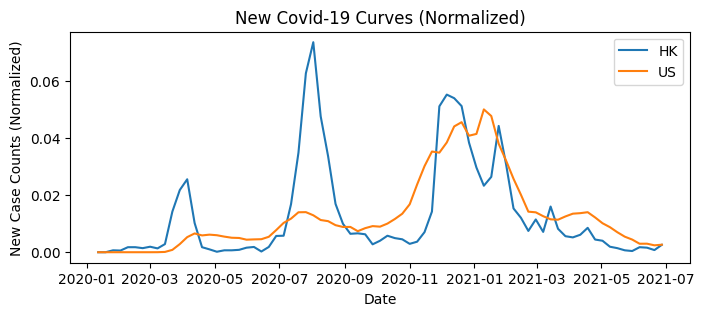

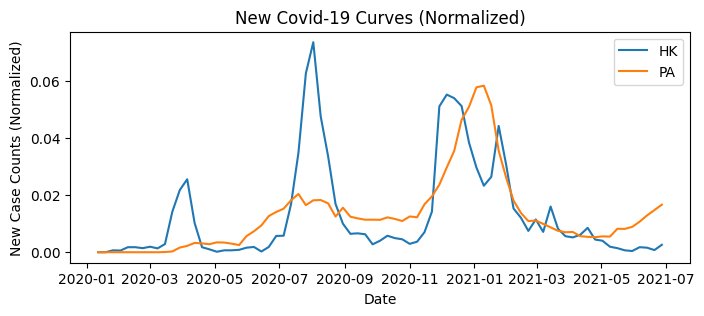

In [12]:
for cntry, dist in first_4_wave_top_n_cntry_dist_list:
    plot_case_count_line_chart(first_4_wave_cnt,
                               cntry,
                               True)

## Analysis - Fifth Wave

In [13]:
fifth_wave_cntry_dist_list= list()
for col in col_list:
    if (fifth_wave_cnt[col] != 0).any():
        dist = covid_module.get_distance_betwn_columns(fifth_wave_cnt, 'HK', col)
        fifth_wave_cntry_dist_list.append((col, dist))

fifth_wave_cntry_dist_list = sorted(fifth_wave_cntry_dist_list, key=lambda item: item[1])
fifth_wave_top_n_cntry_dist_list = fifth_wave_cntry_dist_list[:top_n_nbr]

In [14]:
print(f'The curve distances of the top {top_n_nbr} countries most similar to Hong Kong are:') 
for cntry_cd, dist in fifth_wave_top_n_cntry_dist_list:
    cntry_name = cntry_name_dict[cntry_cd]['cntry_name']
    print(f'{cntry_cd} - {cntry_name} has curve similarity score {1/dist:.4f} with HK.')

The curve distances of the top 2 countries most similar to Hong Kong are:
BN - Brunei has curve similarity score 1.4807 with HK.
KR - South Korea has curve similarity score 1.3242 with HK.


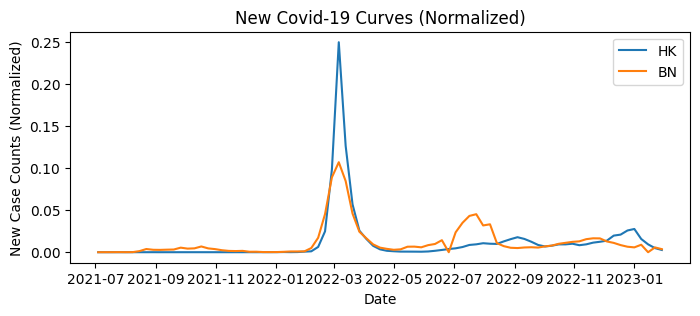

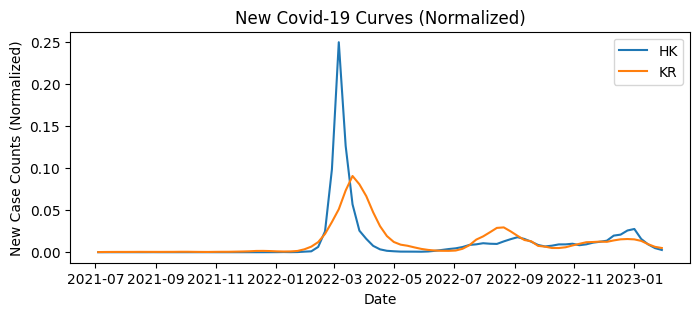

In [15]:
for cntry, dist in fifth_wave_top_n_cntry_dist_list:
    plot_case_count_line_chart(fifth_wave_cnt,
                               cntry,
                               True)